# Result Analysis

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
import torch
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/figures'),
 'raw_csv': PosixPath('../data/raw_dataset.csv'),
 'proc_csv': PosixPath('../data/proc_dataset.csv'),
 'imminent_adm_cols': ['hadm_id', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'prolonged_stay_label'],
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime'],
 'dates': ['charttime', 'intime'],
 'ia_thresh': {'lr': 0.45, 'rf': 0.27, 'gbm': 0.435, 'mlp': 0.2},
 'ps_thresh': {'lr': 0.39, 'rf': 0.36, 'gbm': 0.324, 'mlp': 0.27}}

## 100 Run Performance Results

In [3]:
models = list(args.ia_thresh.keys())

ia_bams = {}
ps_bams = {}

for model in models:
  with open(args.workdir/model/'imminent_adm_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
  ia_bams[model] = BinaryAvgMetrics(targs, preds, probs)
    
  with open(args.workdir/model/'prolonged_stay_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)    
  ps_bams[model] = BinaryAvgMetrics(targs, preds, probs)    

ia_metrics = {}
ps_metrics = {}

for key in ia_bams.keys():
  ia_metrics[key] = []
  ps_metrics[key] = []
  for i in range(len(ia_bams[key].get_avg_metrics())):
    ia_metrics[key].append(ia_bams[key].get_avg_metrics().iloc[i]['Value'])
  for i in range(len(ps_bams[key].get_avg_metrics())):
    ps_metrics[key].append(ps_bams[key].get_avg_metrics().iloc[i]['Value'])    

ia_metrics = pd.DataFrame(ia_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
ps_metrics = pd.DataFrame(ps_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])

In [4]:
ia_metrics

,lr,rf,gbm,mlp
sensitivity,84.1,82.6,82.6,82.1
specificity,57.6,64.8,64.5,63.6
ppv,38.5,42.5,42.4,41.6
auroc,79.1,80.8,81.0,80.4
npv,91.9,92.1,92.1,91.8
f1,52.7,56.1,56.0,55.2


In [5]:
ps_metrics

,lr,rf,gbm,mlp
sensitivity,82.7,69.1,71.9,71.3
specificity,24.2,39.9,35.4,37.4
ppv,39.9,41.1,40.3,41.0
auroc,55.5,56.3,55.3,56.2
npv,69.6,68.0,67.4,68.2
f1,53.7,51.4,51.6,51.9


## Checkpoint

In [6]:
model = 'lr'

In [7]:
ia, ps = ia_bams[model], ps_bams[model]

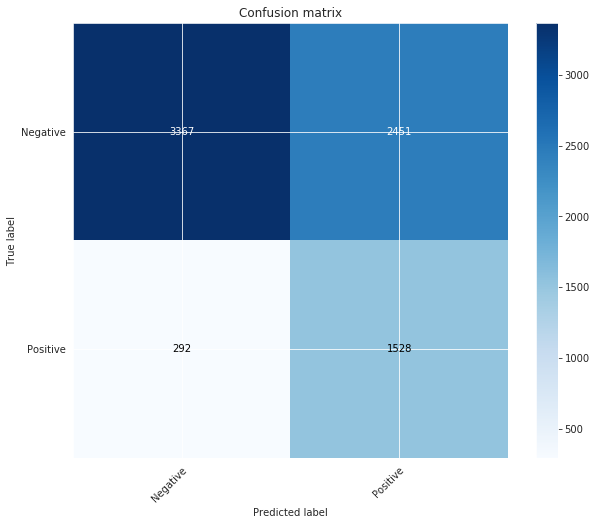

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, ia.cm_avg, classes=['Negative', 'Positive'], normalize=False, title='Confusion matrix')

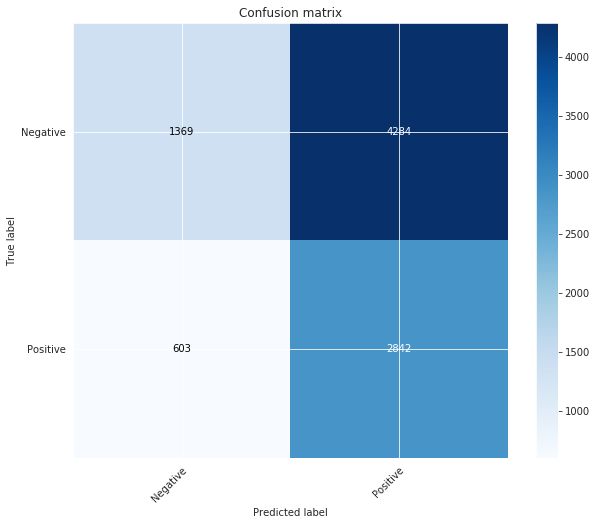

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, ps.cm_avg, classes=['Negative', 'Positive'], normalize=False, title='Confusion matrix')

In [ ]:
sensitivity = tps/(tps + fns)

In [ ]:
sensitivity

In [ ]:
ppv = tps/(tps + fps)

In [ ]:
ppv

## Mean AUC

In [ ]:
model = 'mlp'
ia_bams[model].get_avg_metrics(conf=0.5)

In [ ]:
model = 'mlp'
ps_bams[model].get_avg_metrics(conf=0.5)

In [ ]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

In [ ]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(ia_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(['Logistic Regression', 'Random Forests', 'Gradient Boosting Machines', 'Multilayer Perceptron'])
fig.savefig(args.figdir/'ia_mean_roc.tif', dpi=300)

In [ ]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(ps_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(['Logistic Regression', 'Random Forests', 'Gradient Boosting Machines', 'Multilayer Perceptron'])
fig.savefig(args.figdir/'ps_mean_roc.tif', dpi=300)

## Probability Plots

In [ ]:
df = pd.read_csv(args.proc_csv, usecols=args.cols, parse_dates=args.dates)
df['relative_charttime'] = (df['charttime'] - df['intime'])

imminent_df = df.loc[(df['imminent_label'] != -1)][['scispacy_note', 'imminent_label', 'relative_charttime']].reset_index()
discharge_df = df[['scispacy_note', 'discharge_label', 'relative_charttime']].reset_index()

In [ ]:
interval_hours=12
starting_day = -20
ending_day = -1

### Imminent ICU Admission

In [ ]:
model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
imminent_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], imminent_df, 'lr', args.imminent_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], imminent_df, 'rf', args.imminent_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], imminent_df, 'gbm', args.imminent_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

### ICU Discharge

In [ ]:
model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary)
discharge_df[f'{model}_prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plot_prob(ax[0], discharge_df, 'lr', args.discharge_threshold['lr'], starting_day, ending_day, interval_hours)
plot_prob(ax[1], discharge_df, 'rf', args.discharge_threshold['rf'], starting_day, ending_day, interval_hours)
plot_prob(ax[2], discharge_df, 'gbm', args.discharge_threshold['gbm'], starting_day, ending_day, interval_hours)

fig.text(0.5, 0.08, 'Time to ICU (days)', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', rotation='vertical')

## Word Clouds

### Imminent ICU Admission

In [ ]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'imminent_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

In [ ]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=25)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

### ICU Discharge

In [ ]:
scores = {}
feature_names = {}

model = 'lr'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.coef_[0]/clf.coef_[0].sum()

model = 'rf'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

model = 'gbm'
with open(args.workdir/model/'discharge_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)

feature_names[model] = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2), vocabulary=vocabulary).get_feature_names()
scores[model] = clf.feature_importances_/clf.feature_importances_.sum()

In [ ]:
model = 'gbm'
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
neg, pos = get_wordcloud(feature_names[model], scores[model], n_words=50)
ax[0].imshow(neg)
ax[0].axis('off')
ax[1].imshow(pos)
ax[1].axis('off')

In [ ]:
# fig.savefig(args.figdir/f'prob.tif', dpi=300)